In [ ]:
!pip install kaggle

In [ ]:
import kagglehub

path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", path)

100%|██████████| 5.20G/5.20G [01:02<00:00, 89.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2


In [ ]:
import pandas as pd

metadata_path = "/root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2/HAM10000_metadata.csv"
metadata_df = pd.read_csv(metadata_path)

print(metadata_df.head())


     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [ ]:
import os

folder1 = "/root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2/HAM10000_images_part_1"
folder2 = "/root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2/HAM10000_images_part_2"

def get_image_path(image_id):
    if os.path.exists(os.path.join(folder1, f"{image_id}.jpg")):
        return os.path.join(folder1, f"{image_id}.jpg")
    elif os.path.exists(os.path.join(folder2, f"{image_id}.jpg")):
        return os.path.join(folder2, f"{image_id}.jpg")
    else:
        return None

metadata_df['image_path'] = metadata_df['image_id'].apply(get_image_path)

print(metadata_df[['image_id', 'image_path']].head())


       image_id                                         image_path
0  ISIC_0027419  /root/.cache/kagglehub/datasets/kmader/skin-ca...
1  ISIC_0025030  /root/.cache/kagglehub/datasets/kmader/skin-ca...
2  ISIC_0026769  /root/.cache/kagglehub/datasets/kmader/skin-ca...
3  ISIC_0025661  /root/.cache/kagglehub/datasets/kmader/skin-ca...
4  ISIC_0031633  /root/.cache/kagglehub/datasets/kmader/skin-ca...


In [ ]:
from sklearn.model_selection import train_test_split

train_val_df, test_df = train_test_split(
    metadata_df,
    test_size=0.2,  
    stratify=metadata_df['dx'],  
)

train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.2,  
    stratify=train_val_df['dx'],  
    random_state=42
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Testing samples: {len(test_df)}")


Training samples: 6409
Validation samples: 1603
Testing samples: 2003


In [ ]:
print(metadata_df[['image_id', 'image_path']].head())


       image_id                                         image_path
0  ISIC_0027419  /root/.cache/kagglehub/datasets/kmader/skin-ca...
1  ISIC_0025030  /root/.cache/kagglehub/datasets/kmader/skin-ca...
2  ISIC_0026769  /root/.cache/kagglehub/datasets/kmader/skin-ca...
3  ISIC_0025661  /root/.cache/kagglehub/datasets/kmader/skin-ca...
4  ISIC_0031633  /root/.cache/kagglehub/datasets/kmader/skin-ca...


In [ ]:
print(train_df.columns)
print(test_df.columns)
print(val_df.columns)


Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'image_path'],
      dtype='object')
Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'image_path'],
      dtype='object')
Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'image_path'],
      dtype='object')


In [ ]:
import os
from PIL import Image

folder1 = "/root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2/HAM10000_images_part_1"
folder2 = "/root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2/HAM10000_images_part_2"

train_output = "/content/resized_train_images"
val_output = "/content/resized_val_images"
test_output = "/content/resized_test_images"

os.makedirs(train_output, exist_ok=True)
os.makedirs(val_output, exist_ok=True)
os.makedirs(test_output, exist_ok=True)

def resize_and_save(image_path, output_folder, size=(224, 224)):
    try:
        image = Image.open(image_path)
        image = image.resize(size)
        image.save(os.path.join(output_folder, os.path.basename(image_path)))
    except Exception as e:
        print(f"Error resizing {image_path}: {e}")

def process_split(dataframe, output_folder):
    for _, row in dataframe.iterrows():
        resize_and_save(row['image_path'], output_folder)

process_split(train_df, train_output)
process_split(val_df, val_output)
process_split(test_df, test_output)

print("Resizing completed.")


Resizing completed.


In [ ]:
import os

print(f"Training images: {len(os.listdir(train_output))}")
print(f"Test images: {len(os.listdir(test_output))}")
print(f"Validation images: {len(os.listdir(val_output))}")


Training images: 6409
Test images: 2003
Validation images: 1603


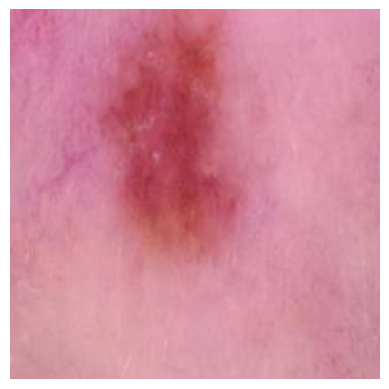

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image

output_folder = "/content/resized_train_images"

image_files = os.listdir(output_folder)

image_path = os.path.join(output_folder, image_files[0])

image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')  
plt.show()


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Columns to use from the metadata
tabular_features = ['age', 'sex', 'localization']

# Preprocessing: one-hot encode categorical features and scale numerical ones
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age']),
        ('cat', OneHotEncoder(), ['sex', 'localization'])
    ]
)

train_tabular = preprocessor.fit_transform(train_df[tabular_features])
val_tabular = preprocessor.transform(val_df[tabular_features])
test_tabular = preprocessor.transform(test_df[tabular_features])

import torch
train_tabular = torch.tensor(train_tabular.toarray(), dtype=torch.float32)
val_tabular = torch.tensor(val_tabular.toarray(), dtype=torch.float32)
test_tabular = torch.tensor(test_tabular.toarray(), dtype=torch.float32)


In [ ]:
import torch.nn as nn
import torchvision.models as models

class MultimodalModel(nn.Module):
    def __init__(self, num_tabular_features, num_classes):
        super(MultimodalModel, self).__init__()

        # Image branch (pre-trained ResNet)
        self.cnn = models.resnet18(pretrained=True)
        self.cnn.fc = nn.Identity() 

        # Tabular branch
        self.tabular = nn.Sequential( #kasuta efficientNeti
            nn.Linear(num_tabular_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        # Fusion layer
        self.fusion = nn.Sequential(
            nn.Linear(64 + 512, 128),  
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, image, tabular_features):
        image_features = self.cnn(image)

        tabular_features = self.tabular(tabular_features)

        combined = torch.cat((image_features, tabular_features), dim=1)

        output = self.fusion(combined)
        return output


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class MultimodalDataset(Dataset):
    def __init__(self, dataframe, tabular_data, transform=None):
        self.dataframe = dataframe
        self.tabular_data = tabular_data
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        image = Image.open(row['image_path']).convert('RGB')
        if self.transform:
            image = self.transform(image)

        tabular_features = self.tabular_data[idx]

        label = row['label']

        return image, tabular_features, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = MultimodalDataset(train_df, train_tabular, transform=transform)
val_dataset = MultimodalDataset(val_df, val_tabular, transform=transform)
test_dataset = MultimodalDataset(test_df, test_tabular, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [ ]:
label_map = {label: idx for idx, label in enumerate(metadata_df['dx'].unique())}

train_df['label'] = train_df['dx'].map(label_map)
val_df['label'] = val_df['dx'].map(label_map)
test_df['label'] = test_df['dx'].map(label_map)

print("Label Map:", label_map)


Label Map: {'bkl': 0, 'nv': 1, 'df': 2, 'mel': 3, 'vasc': 4, 'bcc': 5, 'akiec': 6}


In [ ]:
import numpy as np

train_tabular[torch.isnan(train_tabular)] = 0
test_tabular[torch.isnan(test_tabular)] = 0
val_tabular[torch.isnan(val_tabular)] = 0

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_tabular_features = train_tabular.shape[1]
num_classes = len(label_map)
model = MultimodalModel(num_tabular_features, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 

epochs = 10
best_val_loss = float('inf')
best_val_accuracy = 0.0
best_model_path = "best_multimodal_model.pth"

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, tabular_features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, tabular_features, labels = images.to(device), tabular_features.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images, tabular_features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = correct_train / total_train
    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, tabular_features, labels in val_loader:
            images, tabular_features, labels = images.to(device), tabular_features.to(device), labels.to(device)
            outputs = model(images, tabular_features)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = correct_val / total_val
    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    if val_accuracy > best_val_accuracy or (val_accuracy == best_val_accuracy and val_loss < best_val_loss):
        best_val_accuracy = val_accuracy
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with Validation Accuracy: {val_accuracy:.4f}, Loss: {val_loss:.4f}")

print("Training complete. Loading the best model.")
# Load the best model for further use
model.load_state_dict(torch.load(best_model_path))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 166MB/s]
Epoch 1/10: 100%|██████████| 201/201 [01:20<00:00,  2.49it/s]


Epoch 1, Train Loss: 0.8170, Train Accuracy: 0.7096, Validation Loss: 1.4570, Validation Accuracy: 0.3843
New best model saved with Validation Accuracy: 0.3843, Loss: 1.4570


Epoch 2/10: 100%|██████████| 201/201 [01:19<00:00,  2.53it/s]


Epoch 2, Train Loss: 0.6819, Train Accuracy: 0.7465, Validation Loss: 0.6746, Validation Accuracy: 0.7561
New best model saved with Validation Accuracy: 0.7561, Loss: 0.6746


Epoch 3/10: 100%|██████████| 201/201 [01:22<00:00,  2.44it/s]


Epoch 3, Train Loss: 0.6358, Train Accuracy: 0.7666, Validation Loss: 1.0366, Validation Accuracy: 0.6245


Epoch 4/10: 100%|██████████| 201/201 [01:20<00:00,  2.49it/s]


Epoch 4, Train Loss: 0.5971, Train Accuracy: 0.7805, Validation Loss: 0.6299, Validation Accuracy: 0.7704
New best model saved with Validation Accuracy: 0.7704, Loss: 0.6299


Epoch 5/10: 100%|██████████| 201/201 [01:18<00:00,  2.56it/s]


Epoch 5, Train Loss: 0.5633, Train Accuracy: 0.7922, Validation Loss: 0.6108, Validation Accuracy: 0.7686


Epoch 6/10: 100%|██████████| 201/201 [01:19<00:00,  2.53it/s]


Epoch 6, Train Loss: 0.5122, Train Accuracy: 0.8096, Validation Loss: 0.7221, Validation Accuracy: 0.7779
New best model saved with Validation Accuracy: 0.7779, Loss: 0.7221


Epoch 7/10: 100%|██████████| 201/201 [01:19<00:00,  2.53it/s]


Epoch 7, Train Loss: 0.5008, Train Accuracy: 0.8120, Validation Loss: 0.5894, Validation Accuracy: 0.7960
New best model saved with Validation Accuracy: 0.7960, Loss: 0.5894


Epoch 8/10: 100%|██████████| 201/201 [01:18<00:00,  2.55it/s]


Epoch 8, Train Loss: 0.4499, Train Accuracy: 0.8327, Validation Loss: 0.5873, Validation Accuracy: 0.7879


Epoch 9/10: 100%|██████████| 201/201 [01:18<00:00,  2.56it/s]


Epoch 9, Train Loss: 0.4026, Train Accuracy: 0.8491, Validation Loss: 0.5999, Validation Accuracy: 0.7891


Epoch 10/10: 100%|██████████| 201/201 [01:20<00:00,  2.49it/s]


In [ ]:
model.eval()

model.load_state_dict(torch.load("best_multimodal_model.pth"))

test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for images, tabular_features, labels in test_loader:
        images, tabular_features, labels = images.to(device), tabular_features.to(device), labels.to(device)
        outputs = model(images, tabular_features)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = correct_test / total_test
test_loss /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


<ipython-input-17-68b16f60a258>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_multimodal_model.pth"))


Test Loss: 0.5984, Test Accuracy: 0.7923
